In [82]:
!pip install yelpapi
!pip install numpy
import yelpapi
import json
import requests
from  pprint import  pprint
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

#reading in county data
counties=pd.read_csv("acs2015_county_data.csv")
counties["county_string"] = counties["County"] + " County, " + counties["State"]
listofcounties = counties["county_string"].tolist()
#reading in zipcodes
zipcodes=pd.read_csv("zip_codes_states.csv")
zipcodes["county_string"] = zipcodes["county"] + " County, " + zipcodes["state"]
listofzipcodes=zipcodes["county_string"].unique().tolist()
counties.to_csv("counties.csv")
zipcodes.to_csv("zcs.csv")
fullcountylist = list(set(listofcounties) & set(listofzipcodes))
counties.head(1)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,county_string
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,"Autauga County, Alabama"


In [83]:
#creating regions
WC = ["Washington","Oregon","California","Nevada","Idaho"]
MW = ["Montana","Wyoming","North Dakota","South Dakota","Nebraska","Kansas","Minnesota","Iowa","Missouri",
      "Wisconsin","Illinois","Michigan","Indiana","Ohio","Kentucky"]
SW = ["Arizona","Utah","Colorado","New Mexico","Oklahoma","Texas"]
SE = ["Arkansas","Louisiana","Mississippi","Alabama","Tennessee","Virginia","West Virginia","North Carolina","South Carolina","Georgia","Florida"]
NE = ["District of Columbia","Pennsylvania","Maryland","Delaware","New Jersey","New York","Maine","New Hampshire","Vermont","Massachusetts","Rhode Island","Connecticut"]
counties["Region"]= np.where(counties["State"].isin(WC),'WC',
                    np.where(counties["State"].isin(MW),'MW',
                    np.where(counties["State"].isin(SW),'SW',
                    np.where(counties["State"].isin(SE),'SE',
                    np.where(counties["State"].isin(NE),'NE', 
                             'other')))))

In [84]:
#counties.groupby(["Region"]).sum()["TotalPop"]
cdf = pd.DataFrame(counties,columns=["county_string","Region"])
WClist = (cdf.groupby("Region").get_group("WC")["county_string"]).tolist()
MWlist = (cdf.groupby("Region").get_group("MW")["county_string"]).tolist()
SWlist = (cdf.groupby("Region").get_group("SW")["county_string"]).tolist()
SElist = (cdf.groupby("Region").get_group("SE")["county_string"]).tolist()
NElist = (cdf.groupby("Region").get_group("NE")["county_string"]).tolist()

sample_list = []
sample_list.extend(random.sample(list(set(WClist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(MWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SElist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(NElist) & set(fullcountylist)),2))
sample_list

['Bannock County, Idaho',
 'Storey County, Nevada',
 'Benton County, Iowa',
 'Brule County, South Dakota',
 'Major County, Oklahoma',
 'Conejos County, Colorado',
 'Putnam County, Georgia',
 'Lafayette County, Mississippi',
 'Bradford County, Pennsylvania',
 'Lehigh County, Pennsylvania']

In [85]:
res_df = pd.DataFrame(columns=["name","zipcode","county_string","rating","review_count","category","price","region"])
res_df

,name,zipcode,county_string,rating,review_count,category,price,region


In [86]:
r = 0
for c in sample_list:
    county_string = str(c)
    for term in ["Italian","Mexican","Chinese","American (Traditional)","American (New)","Indian"]:
        #we are allowed 5000 queries per 24 hours. if we run out, we can create another. till then, use this
        yelpkey="IXRN_1GI8f8J9Kj5O5GciqeyFSWR5RMh41_rADGy1KrtQ5ZABGGZEkWwot5mOka0NlzlNxXPmzYXLWk88oOV0N_YxD1MSW4kQRfJnFrwfHLtKrr2HcsjLo6uWBzAWnYx"
        try:
            offset=0
            for loopcount in range(5):
                
                response = requests.get(url="https://api.yelp.com/v3/businesses/search", 
                       params= {"location": county_string,"term": term, "limit":"50", "offset": offset}, 
                       headers={'Authorization': 'bearer %s' % yelpkey})
                responsejson = response.json()
                offset += 50
                try:
                    count=0
            
                    for x in range(0,49):
                        for y in range(0,len(responsejson["businesses"][x]["categories"])):
                            if ((str(responsejson["businesses"][x]["categories"][y]["title"])==str(term)) and 
                                (responsejson["businesses"][x]["review_count"] > 0)):
                                zc = int(responsejson["businesses"][x]["location"]["zip_code"])
                                if (zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0]== county_string):
                                    
                                    print("\n",responsejson["businesses"][x]["name"],
                                        responsejson["businesses"][x]["location"]["zip_code"],
                                        zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0],
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        responsejson["businesses"][x]["categories"][y]["title"])
                                    res_df.loc[r]=[responsejson["businesses"][x]["name"],
                                        str(zc),
                                        county_string,
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        term,
                                        responsejson["businesses"][x]["price"],
                                        "region"
                                                  ]
                                    count += 1
                                    r += 1
                except:
                    
                    break
    
                print("End of list. Found", count, term, "restaurants in", county_string)
        except:
            print("Error: this shouldn't happen")
            break



 Cafe Tuscano 83201 Bannock County, Idaho 4.0 78 Italian

 Buddy's Italian Restaurant 83201 Bannock County, Idaho 3.5 78 Italian

 Villano's Italian 83204 Bannock County, Idaho 3.5 25 Italian

 PV's Pasta & Vino 83201 Bannock County, Idaho 4.0 12 Italian

 Pizza Hut 83201 Bannock County, Idaho 1.5 6 Italian

 El Caporal 83201 Bannock County, Idaho 4.5 57 Mexican

 El Herradero 83201 Bannock County, Idaho 4.0 103 Mexican

 Señor Garcia's Puerto Vallarta 83201 Bannock County, Idaho 4.0 20 Mexican

 Mama Inez 83201 Bannock County, Idaho 3.5 30 Mexican

 Chapala Mexican Resturant 83202 Bannock County, Idaho 3.5 14 Mexican

 Las Palomas Mexican Grill 83201 Bannock County, Idaho 5.0 2 Mexican

 Chang's Garden 83201 Bannock County, Idaho 4.0 33 Chinese

 Mandarin House 83201 Bannock County, Idaho 3.5 30 Chinese

 New Hong Kong Restaurant 83201 Bannock County, Idaho 4.0 6 Chinese

 The Little Rock Cafe 83250 Bannock County, Idaho 4.5 37 American (Traditional)

 Sandbaggers Bar & Grill 83201 B


 Kam Bo Chinese Restaurant 18848 Bradford County, Pennsylvania 3.5 10 Chinese

 Great Wall Chinese Buffet 18848 Bradford County, Pennsylvania 2.5 3 Chinese

 Woody's Ale House & Grille 18848 Bradford County, Pennsylvania 4.5 10 American (Traditional)

 Suky's Diner 18848 Bradford County, Pennsylvania 3.5 5 American (Traditional)

 Flatiron Bar & Grill 18840 Bradford County, Pennsylvania 5.0 2 American (New)

 Slice of Italy 18104 Lehigh County, Pennsylvania 4.5 98 Italian

 Fiorentina Grill 18031 Lehigh County, Pennsylvania 4.0 50 Italian

 Paese Mio 18106 Lehigh County, Pennsylvania 4.0 83 Italian

 Vivo Italian Kitchen 18104 Lehigh County, Pennsylvania 4.5 15 Italian

 Mama's Italian Grill 18031 Lehigh County, Pennsylvania 4.0 61 Italian

 Florence Italian Grille 18031 Lehigh County, Pennsylvania 3.0 74 Italian

 Villa Lentini Ristorante 18037 Lehigh County, Pennsylvania 4.0 17 Italian

 Centro 18101 Lehigh County, Pennsylvania 4.0 79 Italian

 Gio Italian Grill 18062 Lehigh County,

In [87]:
res_df.to_csv("output1804071028.csv")
try:
    res_df.price.replace(["$","$$","$$$","$$$$"],[1,2,3,4],inplace=True)
except:
    print("Already done")
try:
    res_df.category.replace(["American (New)","American (Traditional)"],["American","American"],inplace=True)
except:
    print("Already done")
res_df


,name,zipcode,county_string,rating,review_count,category,price,region
0,Cafe Tuscano,83201,"Bannock County, Idaho",4.0,78,Italian,2,region
1,Buddy's Italian Restaurant,83201,"Bannock County, Idaho",3.5,78,Italian,2,region
2,Villano's Italian,83204,"Bannock County, Idaho",3.5,25,Italian,2,region
3,PV's Pasta & Vino,83201,"Bannock County, Idaho",4.0,12,Italian,2,region
4,Pizza Hut,83201,"Bannock County, Idaho",1.5,6,Italian,2,region
5,El Caporal,83201,"Bannock County, Idaho",4.5,57,Mexican,2,region
6,El Herradero,83201,"Bannock County, Idaho",4.0,103,Mexican,1,region
7,Señor Garcia's Puerto Vallarta,83201,"Bannock County, Idaho",4.0,20,Mexican,2,region
8,Mama Inez,83201,"Bannock County, Idaho",3.5,30,Mexican,2,region
9,Chapala Mexican Resturant,83202,"Bannock County, Idaho",3.5,14,Mexican,2,region


In [88]:
res_df= pd.merge(res_df,counties,how="left",on="county_string")
res_df.head()

,name,zipcode,county_string,rating,review_count,category,price,region,CensusId,State,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,Cafe Tuscano,83201,"Bannock County, Idaho",4.0,78,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
1,Buddy's Italian Restaurant,83201,"Bannock County, Idaho",3.5,78,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
2,Villano's Italian,83204,"Bannock County, Idaho",3.5,25,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
3,PV's Pasta & Vino,83201,"Bannock County, Idaho",4.0,12,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
4,Pizza Hut,83201,"Bannock County, Idaho",1.5,6,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC


In [89]:
itadf = res_df.groupby(res_df["category"]).get_group("Italian")
mexdf = res_df.groupby(res_df["category"]).get_group("Mexican")
chndf = res_df.groupby(res_df["category"]).get_group("Chinese")
usadf = res_df.groupby(res_df["category"]).get_group("American")
inddf = res_df.groupby(res_df["category"]).get_group("Indian")
res_df
# CHA = res_df.groupby(res_df["county_string"]).get_group("Mecklenburg County, North Carolina")
# CHAbreakdown = pd.DataFrame(CHA["category"].value_counts()).T.reset_index()
# CHAbreakdown["county_string"]="Mecklenburg County, North Carolina"
# CHA_price_avg = CHA.groupby(res_df["price"]).mean()
# CHA_price_count = CHA["price"].value_counts()

# RAL = res_df.groupby(res_df["county_string"]).get_group("Wake County, North Carolina")
# RALbreakdown = pd.DataFrame(RAL["category"].value_counts()).T.reset_index()
# RALbreakdown["county_string"]="Wake County, North Carolina"
# RAL_price_avg = RAL.groupby(res_df["price"]).mean()
# RAL_price_count = RAL["price"].value_counts()

# ATL = res_df.groupby(res_df["county_string"]).get_group("Fulton County, Georgia")
# ATLbreakdown = pd.DataFrame(ATL["category"].value_counts()).T.reset_index()
# ATLbreakdown["county_string"]="Fulton County, Georgia"
# ATL_price_avg = ATL.groupby(res_df["price"]).mean()
# ATL_price_count = ATL["price"].value_counts()

# MEM = res_df.groupby(res_df["county_string"]).get_group("Shelby County, Tennessee")
# MEMbreakdown = pd.DataFrame(MEM["category"].value_counts()).T.reset_index()
# MEMbreakdown["county_string"]="Shelby County, Tennessee"
# MEM_price_avg = MEM.groupby(res_df["price"]).mean()
# MEM_price_count = MEM["price"].value_counts()


# ORL = res_df.groupby(res_df["county_string"]).get_group("Orange County, Florida")
# ORLbreakdown = pd.DataFrame(ORL["category"].value_counts()).T.reset_index()
# ORLbreakdown["county_string"]="Orange County, Florida"
# ORL_price_avg = ORL.groupby(res_df["price"]).mean()
# ORL_price_count = ORL["price"].value_counts()

# MIL = res_df.groupby(res_df["county_string"]).get_group("Milwaukee County, Wisconsin")
# MILbreakdown = pd.DataFrame(MIL["category"].value_counts()).T.reset_index()
# MILbreakdown["county_string"]="Milwaukee County, Wisconsin"
# MIL_price_avg = MIL.groupby(res_df["price"]).mean()
# MIL_price_count = MIL["price"].value_counts()

# SFC = res_df.groupby(res_df["county_string"]).get_group("San Francisco County, California")
# SFCbreakdown = pd.DataFrame(SFC["category"].value_counts()).T.reset_index()
# SFCbreakdown["county_string"]="San Francisco County, California"
# SFC_price_avg = SFC.groupby(res_df["price"]).mean()
# SFC_price_count = SFC["price"].value_counts()

# AUS = res_df.groupby(res_df["county_string"]).get_group("Travis County, Texas")
# AUSbreakdown = pd.DataFrame(AUS["category"].value_counts()).T.reset_index()
# AUSbreakdown["county_string"]="Travis County, Texas"
# AUS_price_avg = AUS.groupby(res_df["price"]).mean()
# AUS_price_count = AUS["price"].value_counts()

# PIT = res_df.groupby(res_df["county_string"]).get_group("Allegheny County, Pennsylvania")
# PITbreakdown = pd.DataFrame(PIT["category"].value_counts()).T.reset_index()
# PITbreakdown["county_string"]="Allegheny County, Pennsylvania"
# PIT_price_avg = PIT.groupby(res_df["price"]).mean()
# PIT_price_count = PIT["price"].value_counts()


,name,zipcode,county_string,rating,review_count,category,price,region,CensusId,State,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,Cafe Tuscano,83201,"Bannock County, Idaho",4.0,78,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
1,Buddy's Italian Restaurant,83201,"Bannock County, Idaho",3.5,78,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
2,Villano's Italian,83204,"Bannock County, Idaho",3.5,25,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
3,PV's Pasta & Vino,83201,"Bannock County, Idaho",4.0,12,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
4,Pizza Hut,83201,"Bannock County, Idaho",1.5,6,Italian,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
5,El Caporal,83201,"Bannock County, Idaho",4.5,57,Mexican,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
6,El Herradero,83201,"Bannock County, Idaho",4.0,103,Mexican,1,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
7,Señor Garcia's Puerto Vallarta,83201,"Bannock County, Idaho",4.0,20,Mexican,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
8,Mama Inez,83201,"Bannock County, Idaho",3.5,30,Mexican,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
9,Chapala Mexican Resturant,83202,"Bannock County, Idaho",3.5,14,Mexican,2,region,16005,Idaho,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC


In [90]:
TOTAL_price_avg = res_df.groupby(["price"]).mean()
rescount = res_df.groupby(["county_string"]).count()["name"].reset_index()
rescount.columns=['county_string', 'restaurant_count']
TOTAL_county_reviews = res_df.groupby(["county_string"]).review_count.sum().reset_index()
TOTAL_county_reviews.columns=["county_string","review_count"]
TOTAL_county_avg = res_df.groupby(res_df["county_string"]).mean().reset_index()

county_stats = TOTAL_county_avg.merge(TOTAL_county_reviews, on="county_string")
csdf = county_stats.merge(counties, on="county_string")
c_df = rescount.merge(csdf, on="county_string")
c_df

,county_string,restaurant_count,rating,price,CensusId_x,TotalPop_x,Men_x,Women_x,Hispanic_x,White_x,...,OtherTransp_y,WorkAtHome_y,MeanCommute_y,Employed_y,PrivateWork_y,PublicWork_y,SelfEmployed_y,FamilyWork_y,Unemployment_y,Region
0,"Bannock County, Idaho",44,3.568182,1.681818,16005.0,83604.0,41666.0,41938.0,7.7,85.3,...,2.2,3.8,17.9,37206,73.0,20.8,6.0,0.2,7.2,WC
1,"Benton County, Iowa",1,4.000000,1.000000,19011.0,25803.0,12888.0,12915.0,1.3,96.8,...,1.9,5.1,23.9,13080,79.5,13.0,7.4,0.1,4.7,MW
2,"Bradford County, Pennsylvania",5,3.800000,2.200000,42015.0,62228.0,30666.0,31562.0,1.4,96.2,...,1.1,3.5,22.9,26689,82.7,9.9,7.1,0.2,5.6,NE
3,"Brule County, South Dakota",8,3.625000,1.625000,46015.0,5330.0,2621.0,2709.0,0.4,85.8,...,2.2,8.3,13.9,2583,66.4,16.3,15.4,1.9,2.6,MW
4,"Conejos County, Colorado",5,4.000000,1.600000,8021.0,8249.0,4111.0,4138.0,54.4,43.3,...,1.0,5.7,22.6,3021,65.8,21.3,12.8,0.0,9.7,SW
5,"Lafayette County, Mississippi",16,3.625000,1.562500,28071.0,51169.0,24919.0,26250.0,2.3,70.4,...,2.0,2.9,17.7,22584,67.2,27.4,5.4,0.0,8.4,SE
6,"Lehigh County, Pennsylvania",46,4.043478,1.978261,42077.0,356756.0,173680.0,183076.0,21.1,68.5,...,0.9,4.1,24.9,170448,87.0,8.5,4.4,0.1,8.5,NE
7,"Major County, Oklahoma",2,3.750000,1.500000,40093.0,7700.0,3854.0,3846.0,8.9,85.9,...,2.9,3.3,21.9,3518,72.6,15.1,11.5,0.9,5.4,SW
8,"Putnam County, Georgia",11,3.681818,1.636364,13237.0,21247.0,10565.0,10682.0,6.6,65.3,...,2.3,3.6,25.9,9448,77.2,15.8,7.0,0.0,6.3,SE
9,"Storey County, Nevada",2,4.000000,1.500000,32029.0,3929.0,1882.0,2047.0,3.7,90.7,...,0.0,6.6,27.9,1777,72.9,16.4,10.7,0.0,10.3,WC


In [92]:
current_county="Lehigh County, Pennsylvania"
WCO = res_df.groupby(res_df["county_string"]).get_group(current_county)
WCObreakdown = pd.DataFrame(WCO["category"].value_counts()).T.reset_index()
WCOrate = pd.DataFrame(WCO["rating"].value_counts()).T.reset_index()
WCObreakdown["county_string"]=current_county
WCO_price_avg = WCO.groupby(res_df["price"]).mean()
WCO_price_count = WCO["price"].value_counts()
WCObreakdown


,index,American,Italian,Indian,Chinese,Mexican,county_string
0,category,20,15,5,3,3,"Lehigh County, Pennsylvania"


In [93]:
comp_df = pd.DataFrame(columns=["Italian","Mexican","Chinese","American", "Indian","county_string"])
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.reset_index()
del comp_df["index"]
del comp_df["level_0"]
#comp_df["Totals"]=comp_df["Italian"]+comp_df["Mexican"]+comp_df["Chinese"]+comp_df["Indian"]+comp_df["American"]
comp_df

,American,Chinese,Indian,Italian,Mexican,county_string
0,20,3,5,15,3,"Lehigh County, Pennsylvania"
1,20,3,5,15,3,"Lehigh County, Pennsylvania"
2,20,3,5,15,3,"Lehigh County, Pennsylvania"
3,20,3,5,15,3,"Lehigh County, Pennsylvania"
4,20,3,5,15,3,"Lehigh County, Pennsylvania"
5,20,3,5,15,3,"Lehigh County, Pennsylvania"
6,20,3,5,15,3,"Lehigh County, Pennsylvania"
7,20,3,5,15,3,"Lehigh County, Pennsylvania"
8,20,3,5,15,3,"Lehigh County, Pennsylvania"


In [94]:
fig, axes = plt.subplots(3,3,figsize= (16,9))
for i, (idx, row) in enumerate(comp_df.set_index("county_string").iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum()*.01)]
    ax.pie(row, labels=row.index)
    ax.set_title(idx)
fig.subplots_adjust(wspace=1)

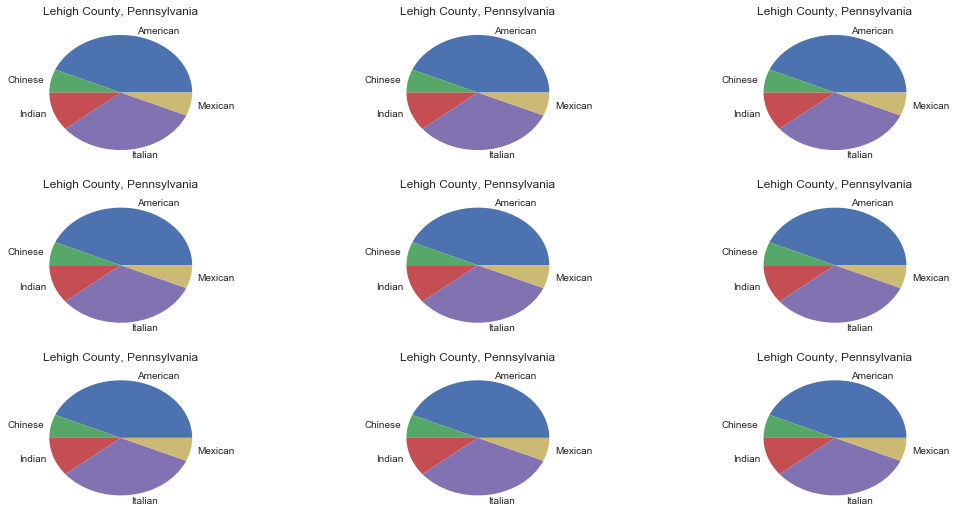

In [95]:
plt.show()

In [96]:
labels = ["Italian","Mexican","Chinese","American", "Indian"]
# Values of each group
bars =[[],[],[],[]]
for label in labels:
    df= res_df.loc[res_df["category"]==label, :]
    counts = df["price"].value_counts()
    for price in range(1,5):
        try:
            bars[price-1].append(counts[price])
        except: 
            bars[price-1].append(0)
print(bars[1])

[28, 8, 5, 42, 7]


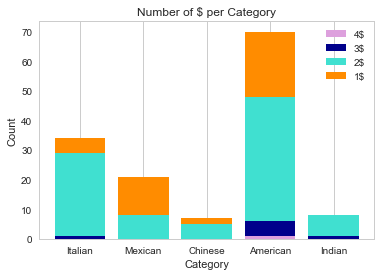

In [125]:
from matplotlib import rc
sns.set()
# orgPalette = sns.color_palette("Set2", len(res_by_price))
# sns.set_palette(orgPalette)
sns.set_style("whitegrid", {'legend.frameon':False})


# y-axis in bold
# rc('font', weight='bold')

figsize= (100, 100, 50)
 
# Values of each group
bars1 = bars[0]
bars2 = bars[1]
bars3 = bars[2]
bars4 = bars[3]
x = np.arange(len(bars1))


four_dolla=plt.bar(x, bars4, color="plum")
three_dolla=plt.bar(x, bars3, color="darkblue", bottom=bars4)
two_dolla=plt.bar(x, bars2, color="turquoise", bottom=list(map(lambda x,y: x+y, bars3,bars4)))
one_dolla=plt.bar(x, bars1, color="darkorange", bottom=list(map(lambda x,y,z: x+y+z, bars3,bars4,bars2)))

plt.xticks(x, ["Italian","Mexican","Chinese","American", "Indian"])

plt.grid(axis='y')
plt.xlabel("Category")
plt.ylabel('Count')
plt.title('Number of $ per Category')
    
plt.legend((four_dolla[0], three_dolla[0],two_dolla[0], one_dolla[0]), ('4$', '3$','2$', '1$'), loc="best")


# Show graphic
plt.show()
plt.savefig("stacked.png")

In [119]:
region = ["NE","MW","WC","SW","SE"]
# Values of each group
r_bars =[[],[],[],[]]
for r in region:
    reg_bars= res_df.loc[res_df["Region"]==r, :]
    reg_counts = reg_bars["price"].value_counts()
    for price in range(1,5):
        try:
            r_bars[price-1].append(reg_counts[price])
        except: 
            r_bars[price-1].append(0)
print(r_bars)


[[6, 4, 16, 3, 13], [39, 5, 29, 4, 13], [6, 0, 1, 0, 0], [0, 0, 0, 0, 1]]


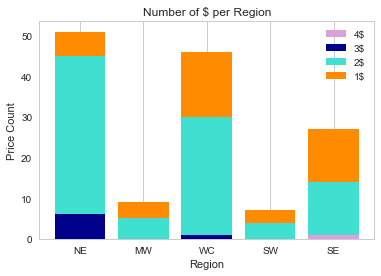

In [126]:
#### sns.set()
# orgPalette = sns.color_palette("Set2", len(res_by_price))
# sns.set_palette(orgPalette)
sns.set_style("whitegrid", {'legend.frameon':False})

figsize= (100, 100, 50)
 
# Values of each group
bars1 = r_bars[0]
bars2 = r_bars[1]
bars3 = r_bars[2]
bars4 = r_bars[3]
x = np.arange(len(bars1))


four_dol = plt.bar(x, bars4, color="plum")
three_dol =plt.bar(x, bars3, color="darkblue", bottom=bars4)
two_dol =plt.bar(x, bars2, color="turquoise", bottom=list(map(lambda x,y: x+y, bars3,bars4)))
one_dol =plt.bar(x, bars1, color="darkorange", bottom=list(map(lambda x,y,z: x+y+z, bars3,bars4,bars2)))

plt.xticks(x, ["NE","MW","WC","SW","SE","NE","WC","SE"])

plt.grid(axis='y')
plt.xlabel("Region")
plt.ylabel('Price Count')
plt.title('Number of $ per Region')

plt.legend((four_dol[0], three_dol[0],two_dol[0], one_dol[0]), ('4$', '3$','2$', '1$'), loc="best")

# Show graphic
plt.show()
plt.savefig("stacked2.png")